In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [2]:
X, y = make_classification(n_samples=5000, n_features=5, n_redundant=2,
                           n_classes=2, weights=[0.7], class_sep=0.7, random_state=15)



<h1><font color='Geen'> 8F: Implementing Platt Scaling to find P(Y==1|X)</font></h1>

# TASK F

In [3]:
def initialize_weights(row_vector):
    ''' In this function, we will initialize our weights and bias'''
    #initialize the weights as 1d array consisting of all zeros similar to the dimensions of row_vector
    #you use zeros_like function to initialize zero, check this link https://docs.scipy.org/doc/numpy/reference/generated/numpy.zeros_like.html
    #initialize bias to zero
    
    w = np.zeros_like(row_vector)
    b = 0

    return w,b

In [4]:
def decision_function(x_cv,supp_vec,dual_coef,intercept,gamma):
    fcv = []
    
    for xq in x_cv:
        sigma_sum = 0

        for idx, vec in enumerate(supp_vec):
            l2_norm = np.linalg.norm(vec-xq)**2

            sigma_sum += dual_coef[0,idx] * np.exp(-gamma*l2_norm)
        sigma_sum += intercept[0]
        fcv.append(sigma_sum)

    return np.array(fcv)

In [5]:
def caliberate(y_train,y_cv):
     
    n_p = np.count_nonzero(y_train)
    n_m =  len(y_train)- n_p

    y_plus = (n_p+1)/(n_p+2)
    y_minus = 1/(n_m +2)

    cal_y = []
    for y in y_cv:
        if y == 1:
            cal_y.append(y_plus)
        else:
            cal_y.append(y_minus)
    return np.array(cal_y)

In [6]:
def gradient_db(x,y,w,b):
     '''In this function, we will compute gradient w.r.to b '''
     db = y - sigmoid(np.dot(w,x)+b)
     return db

In [7]:
def gradient_dw(x,y,w,b,alpha,N):
    '''In this function, we will compute the gardient w.r.to w '''
    dw = (x*(y-sigmoid(np.dot(w,x)+b))-(alpha/N*w)).sum()
    
    return dw

In [8]:
def sigmoid(z):
    ''' In this function, we will return sigmoid of z'''
    # compute sigmoid(z) and return

    return 1/(1+np.exp(-z))

In [9]:
def logloss(y_true,y_pred):
    # you have been given two arrays y_true and y_pred and you have to calculate the logloss
    #while dealing with numpy arrays you can use vectorized operations for quicker calculations as compared to using loops
    #https://www.pythonlikeyoumeanit.com/Module3_IntroducingNumpy/VectorizedOperations.html
    #https://www.geeksforgeeks.org/vectorized-operations-in-numpy/
    #write your code here
    n = len(y_true)
    loss = -1*(1/n)*((y_true*np.log10(y_pred) + (1-y_true)*np.log10(1-y_pred)).sum())
    return loss

In [10]:
def sgd_train(f_cv,y_cv,epoch,alpha,eta0):
    tol = 0.001

    test_loss = []
    N= len(f_cv)
    w,b = initialize_weights(f_cv) # Initialize the weights
    


    for e in range(epoch):          # for every epoch
        print("epoch",e+1)
        y_pred = []
        for i in range(N):  # for every data point(X_train,y_train)
            dw = gradient_dw(f_cv[i],y_cv[i],w,b,alpha,N)  #compute gradient w.r.to w (call the gradient_dw() function)
            db = gradient_db(f_cv[i],y_cv[i],w,b)          #compute gradient w.r.to b (call the gradient_db() function)
            w =  w + eta0*dw       #update w, b
            b =  b + eta0*db
            z = sigmoid(np.dot(w,f_cv[i])+b)
            y_pred.append(z)
        y_pred = np.array(y_pred)
        test_loss.append(logloss(y_pred,y_cv))
        

        if e >0 and abs(test_loss[e]-test_loss[e-1])<=tol:
            break
            

    return w,b,test_loss,e+1

##Step 1: Splitting into Xtrain (60),  Xcv (20),  Xtest (20)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train,X_cv,y_train,y_cv = train_test_split(X_train,y_train,test_size=0.25,random_state= 12)

##Step 2: Training SVC(gamma=0.001,C=100) on ($X_{train}$,$y_{train}$)

In [12]:
clf = SVC(C=100,gamma=0.001)
clf.fit(X_train,y_train)

SVC(C=100, gamma=0.001)

##Step 3: Getting $f_{cv}$ valueson the $X_{cv}$ data

In [13]:
epoch = 20
gamma = 0.001
eta0 = 0.0001
alpha = 0.0001
f_cv =decision_function(X_cv,clf.support_vectors_,clf.dual_coef_,clf.intercept_,gamma)

##Step 4: Applying SGD on $f_{cv}$ and caliberated $y_{cv}$

In [14]:
cal_y_cv = caliberate(y_train,y_cv)

In [15]:
w,b,loss,e=sgd_train(f_cv,cal_y_cv,epoch,alpha,eta0)

print(loss)


epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
[1396.1064540693774, 1394.0932926914247, 1394.1147975647136, 1394.136544386539, 1394.1581722263236, 1394.1796814288225, 1394.201072648191, 1394.2223465352386, 1394.2435037371845, 1394.2645448976732, 1394.2854706567928, 1394.3062816510976, 1394.3269785136238, 1394.347561873909, 1394.3680323580145, 1394.3883905885373, 1394.4086371846365, 1394.4287727620474, 1394.4487979330981, 1394.4687133067334]


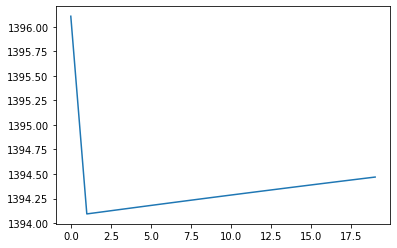

In [16]:
plt.plot(range(e),loss)

In [17]:
f_test = decision_function(X_test,clf.support_vectors_,clf.dual_coef_,clf.intercept_,gamma)
prob_y1 = sigmoid(w*f_test+b)

In [18]:
prob_y1.shape,X_test.shape

((1000,), (1000, 5))

In [19]:
prob_y1

array([7.04692913e-02, 7.91851430e-02, 2.22589336e-01, 9.27288075e-03,
       1.33347234e-03, 7.94518120e-01, 9.58029491e-01, 4.35792716e-02,
       9.46314187e-04, 6.56813289e-01, 9.87879819e-01, 2.62771730e-03,
       2.09445390e-01, 2.78778557e-01, 1.54844292e-01, 9.55259147e-01,
       3.99284262e-03, 5.51554864e-03, 6.24359112e-03, 4.25048940e-02,
       2.27381357e-02, 6.77809154e-04, 9.84737769e-01, 9.41214711e-01,
       9.20121375e-03, 3.96399055e-03, 8.24257620e-04, 1.12538996e-01,
       1.40757674e-01, 8.59687810e-01, 8.99897160e-03, 1.71418057e-03,
       6.86298663e-04, 3.02988165e-03, 9.56699125e-01, 5.21441533e-01,
       4.55434811e-01, 1.92775690e-02, 7.60389289e-01, 9.16879896e-01,
       2.51567939e-03, 6.03179517e-01, 6.33257795e-01, 5.23872712e-01,
       3.74072097e-03, 9.64532834e-01, 6.75739376e-03, 1.83096770e-03,
       8.76643140e-01, 9.76720512e-01, 3.89445073e-01, 5.34392258e-02,
       1.11774627e-02, 2.34895342e-03, 6.60487957e-03, 3.21655960e-02,
      